In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import random as rnd

In [3]:
def draw_plot(
        funcs,
        labels: list[str],
        interval_arg: list[float | int],

        interval_fun: list[float | int]=[],
        points: list[float | int]=[],
        invert=False
):
    x = np.linspace(interval_arg[0], interval_arg[1], 1000)

    Y = [f(x) for f in funcs]

    plt.figure(figsize=(12, 10))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('График функции')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axvline(0, color='black', linewidth=0.8)

    for idx, y in enumerate(Y):
        if invert:
            plt.plot(y, x, label=labels[idx])
        else:
            plt.plot(x, y, label=labels[idx])

    for f in funcs:
        points_y = [f(p) for p in points]
        if invert:
            plt.scatter(points_y, points, c='red', s=100, marker='x')
        else:
            plt.scatter(points, points_y, c='red', s=100, marker='x')

    plt.legend()


    delta_arg = (interval_arg[1] - interval_arg[0]) * 0.02
    if invert:
        plt.ylim([interval_arg[0] - delta_arg, interval_arg[1] + delta_arg])
    else:
        plt.xlim([interval_arg[0] - delta_arg, interval_arg[1] + delta_arg])

    if len(interval_fun) > 0:
        delta_fun = (interval_fun[1] - interval_fun[0]) * 0.02
        if invert:
            plt.xlim([interval_fun[0] - delta_fun, interval_fun[1] + delta_fun])
        else:
            plt.ylim([interval_fun[0] - delta_fun, interval_fun[1] + delta_fun])

    plt.grid(True)
    plt.show()

In [4]:
def map_args(Xs, xk):
    return dict(zip(Xs, xk)) # xs1 -> x0, где x0 это число

### Уравнения

In [5]:
Xs = [
    sp.Symbol('x'),
    sp.Symbol('y')
]

Fs = [
    Xs[1] ** 2 - Xs[0] ** 3 + 1, # y^2 - x^3 +1
    Xs[1] - Xs[0] * Xs[1] ** 3 + 4
]

equations = [
    f'{Fs[0]} = 0',
    f'{Fs[1]} = 0',
]

print(equations)

['-x**3 + y**2 + 1 = 0', '-x*y**3 + y + 4 = 0']


In [6]:
draw_fs1 = (Xs[1]**2 + 1) ** (1 / 3)
draw_fs2 = (Xs[1] + 4) / Xs[1]**3

draw_f1 = sp.lambdify(Xs[1], draw_fs1)
draw_f2 = sp.lambdify(Xs[1], draw_fs2)

draw_fl1 = f'{draw_fs1}'
draw_fl2 = f'{draw_fs2}'

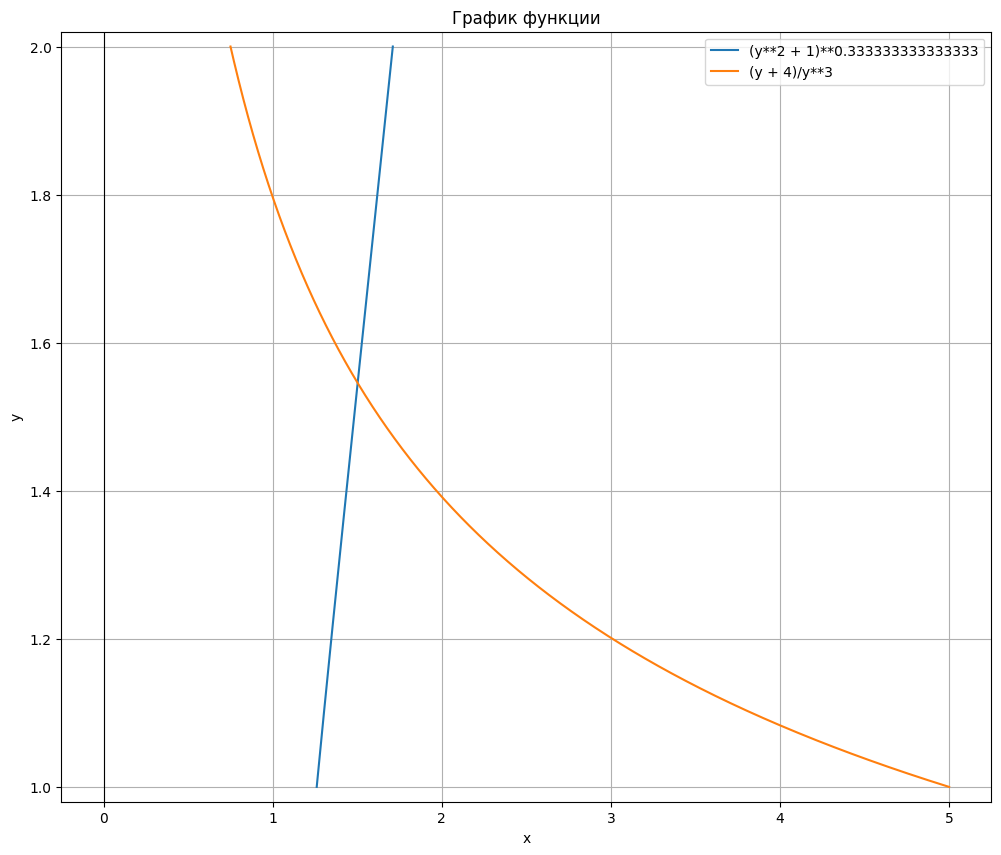

In [7]:
draw_plot([draw_f1, draw_f2], [draw_fl1, draw_fl2], [1, 2], invert=True)

### Метод Ньютона

Записываем якобиан

In [8]:
Jaks = []

for fs in Fs:
    dfs = []
    for xs in Xs:
        dfs.append(fs.diff(xs, 1))

    Jaks.append(dfs)


In [9]:
print(Jaks)

[[-3*x**2, 2*y], [-y**3, -3*x*y**2 + 1]]


Функция для расчета якобиана в xk

In [29]:
def eval_func(F_matrix, xk):
    vals = []
    arg = map_args(Xs, xk)
    for F_row in F_matrix:
        v = []
        for f in F_row:
            v.append(f.subs(arg))

        vals.append(v)

    print(f'result: {vals}')
    result = np.array(vals).astype(float)
    return result if len(F_matrix) > 1 else result[0]

In [11]:
J = eval_func(Jaks, [1, 2])
print(J)

[[ -3.   4.]
 [ -8. -11.]]


In [12]:
v = eval_func([Fs], [1, 2])
print(v)

[ 4. -2.]


In [13]:
print(J.shape)
print(v.shape)

(2, 2)
(2,)


In [14]:
def newton(Fs, xk0, iters=1000, e=1e-3):
    xkn = xk0
    for k in range(iters):
        J = eval_func(Jaks, xkn)
        v = eval_func([Fs], xkn)

        z = np.linalg.solve(J, -v)
        xkn1 = xkn + z

        if np.linalg.norm(xkn1 - xkn) <= e or np.linalg.norm(z) <= e or np.linalg.norm(eval_func([Fs], xkn)) <= e:
            return xkn1, k + 1

        xkn = xkn1

    return xkn, iters

In [15]:
xk0 = [1, 1]

root, iters = newton(Fs, xk0)

In [16]:
print(f'found root {root} in {iters} iterations')

found root [1.50203905 1.5455686 ] in 5 iterations


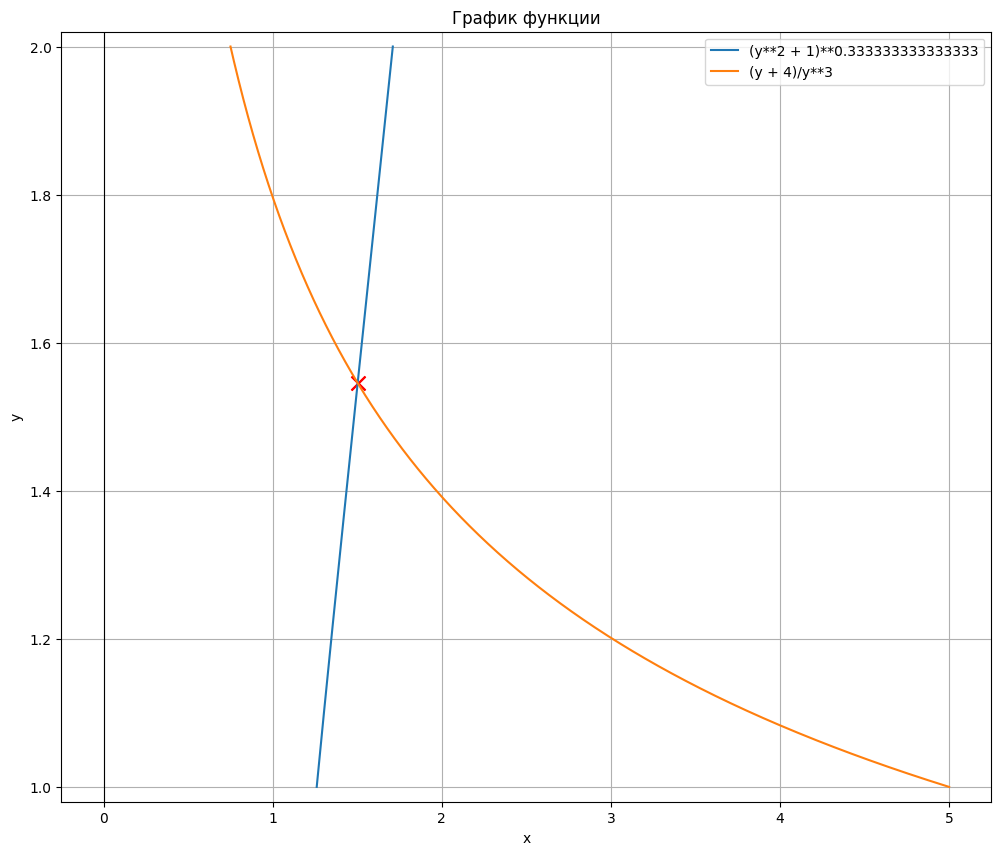

In [17]:
draw_plot([draw_f1, draw_f2], [draw_fl1, draw_fl2], [1, 2], invert=True, points=root[1:])

### Метод простой итерации

In [79]:
phi1_1_s = sp.sqrt(Xs[0]**3 - 1)
phi1_2_s = -sp.sqrt(Xs[0]**3 - 1)

phi2_s = (Xs[1] + 4) / Xs[1]**3

Вместо обычной вектор-формы метода используем дросселирование.
Это когда Xk+1 = Xk + omega(Phi(Xk) - Xk)

In [80]:
Phi_s = sp.Matrix([phi2_s, phi1_1_s])

In [81]:
X0 = [1.5, 2]
omega = 0.2

In [90]:
def simple_iter(Phi_s, X0, omega=0, e=1e-4, max_iter=1000):
    Phi = sp.lambdify(Xs, Phi_s)
    X_n = np.array(X0, dtype=float)

    for k in range(max_iter):
        X_phi = np.array(Phi(*X_n), dtype=float).flatten()

        if omega > 0:
            X_n1 = X_n + omega * (X_phi - X_n)
        else:
            X_n1 = X_phi

        if np.linalg.norm(X_n1 - X_n, ord=np.inf) < e:
            return X_n1, k + 1

        X_n = X_n1

    return X_n, max_iter

In [92]:
root, iters = simple_iter(Phi_s, X0, omega)

In [93]:
print(f'found root {root} in {iters} iterations')

found root [1.50187232 1.54541381] in 109 iterations


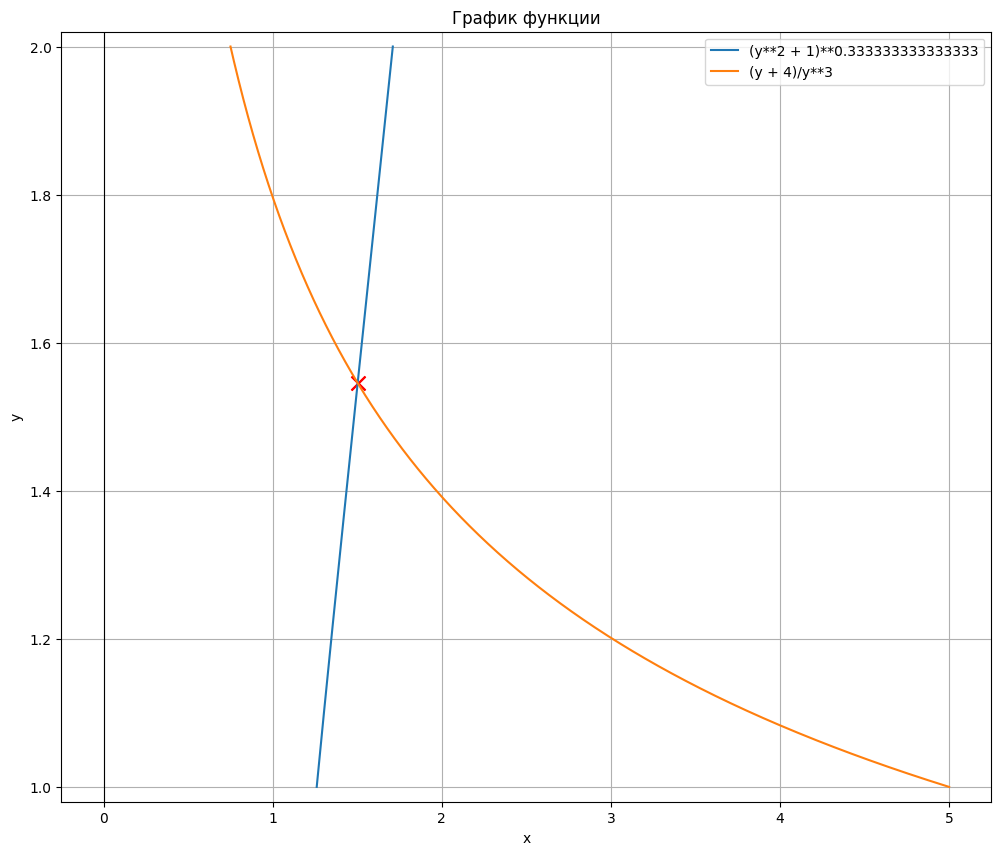

In [94]:
draw_plot([draw_f1, draw_f2], [draw_fl1, draw_fl2], [1, 2], invert=True, points=root[1:])